In [24]:
# Michael Beven
# University of Chicago - Financial Mathematics
# FINM 33150 - Quantitative Strategies and Regression
# Homework 2

# make plots come up in this window - ipython notebook
%matplotlib inline

# import packages
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import Quandl

In [17]:
# write the code in a function, which spits out a final dataframe of results
# makes it easier for analysis
def strat(M,g,j,s,X_code,Y_code,X_close,X_volume,Y_close,Y_volume):
  """
  This function creates a dataframe with results to a spread trading strategy
  (see HW2 of FINM 33150 - Quantitative Strategies and Regression)
  Inputs:
  M ~ return difference calculation time frame.  M cannot exceed the number of 
  trading days between 2013-12-02 and 2014-01-01
  g ~ entering threshold
  j ~ exiting threshold
  s ~ stop loss threshold
  X_code ~ Quandl code for X
  Y_code ~ Quandl code for Y
  X_close ~ X column name for close
  X_volume ~ X column name for volume
  Y_close ~ Y column name for close
  Y_volume ~ Y column name for volume
  Example of calling function:
  strat(10,0.01,0.008,0.10,'GOOG/NYSE_XSD','YAHOO/SMH','GOOG.NYSE_XSD - Close',
  'GOOG.NYSE_XSD - Volume','YAHOO.SMH - Close','YAHOO.SMH - Volume')
  """

  # grab data
  raw_data = Quandl.get(list((X_code,Y_code)),
      authtoken="v21snmSix9KyXBWc1RkF",
      trim_start="2013-12-02",
      trim_end="2015-12-31",
      returns="pandas")

  # take a subset of columns of the close data and volume (volume needed for daily
  # dollar volume)
  raw_data_close = pd.DataFrame(raw_data.ix[:,(X_close,X_volume,Y_close,Y_volume)])
  raw_data_close.columns = ['XP','XV','YP','YV']

  # calculate daily dollar volumes
  XSD_DDV = pd.DataFrame(raw_data_close.loc[:,'XP']*raw_data_close.loc[:,'XV']
  , columns=['XDDV'])

  # create 15 day rolling median of data
  Nt = pd.DataFrame(pd.rolling_median(XSD_DDV.XDDV,15))
  Nt.columns = ['Nt']

  # capital - set K now that we have Nt
  K = np.max(2*Nt.Nt)

  # set up difference calculation of returns based on M
  # create log return columns and sum over M days.  assumes
  # returns are normally distributed

  # log returns
  XR = pd.DataFrame(np.log(raw_data_close['XP']) - np.log(raw_data_close['XP'].shift(1)))
  XR.columns=['XR']
  YR = pd.DataFrame(np.log(raw_data_close['YP']) - np.log(raw_data_close['YP'].shift(1)))
  YR.columns=['YR']

  # difference of X and Y
  Delta = pd.DataFrame(XR.XR-YR.YR)
  Delta.columns=['Delta']

  # previous M day difference 
  DeltaM = pd.DataFrame(pd.rolling_sum(Delta.Delta,M))
  DeltaM.columns = ['DeltaM']

  # set dataframe
  df = pd.concat([raw_data_close,XSD_DDV,XR,YR,Delta,DeltaM,Nt],axis=1)
  df = df[df.index >= '2014-01-01'] # drop unnecessary date range

  # add empty signal column
  Signal = pd.DataFrame(np.zeros((len(df),1))).set_index(df.index)
  Signal.columns = ['Signal']

  # beginning January 1 2014, start generating signals based on g/j
  Signal.Signal[df.DeltaM > g] = 1 # enter trade
  Signal.Signal[df.DeltaM < j] = -1 # exit trade
  for i in range(1,len(df)):
    if Signal.Signal[i] == 0:
      Signal.Signal[i] = Signal.Signal[i-1] # fill in where  Signal = 0 (will already be
      # entered or exited from a trade)
  Signal.Signal[Signal.Signal == -1] = 0 # represent exiting trades with 0 instead of -1

  # account for exiting trades at the end of each month
  EOM = pd.DataFrame(np.zeros((len(df),1)),columns=['EOM']).set_index(df.index)  
  for i in range (1,len(df)):
    if ((df.index.day[i] <= 3) and (df.index.day[i]-df.index.day[i-1] != 1)):
      Signal.Signal[i-1] = 0 
      EOM.EOM[i-1] = 1
      
  # GTC
  GTC = pd.DataFrame(np.zeros((len(df),1)))
  GTC = GTC.set_index(df.index)
  GTC.columns = ['GTC']
  GTC.GTC.ix[0] = 1*(Signal.Signal.ix[0] == 1)
  GTC.GTC = GTC.GTC + 1*((Signal.Signal == 1) & (Signal.shift(1).Signal == 0))
  GTC.GTC = GTC.GTC*(np.abs(np.round(df.Nt/100,0)*df.XP)+np.abs(np.round(df.Nt/100,0)*df.YP))
  for i in range(1,len(df)):
    if (GTC.GTC[i-1] != 0) & (Signal.Signal[i] == 1):
      GTC.ix[i] = GTC.ix[i-1]
  # Stop
  Stop = pd.DataFrame(np.zeros((len(df),1)))
  Stop = Stop.set_index(df.index)   
  Stop.columns = ['Stop']
  Stop.Stop[(GTC.GTC != 0) & (GTC.GTC*s*-1>np.round(Signal.Signal*df.Nt/100,0).shift(1)*df.Delta)] = 1
  Signal.Signal[(GTC.GTC != 0) & (GTC.GTC*s*-1>np.round(Signal.Signal*df.Nt/100,0).shift(1)*df.Delta)] = 0

  # add empty columns for entry and exit points
  Entry = pd.DataFrame(np.zeros((len(df),1)))
  Entry = Entry.set_index(df.index)
  Entry.columns = ['Entry']
  Exit = pd.DataFrame(np.zeros((len(df),1)))
  Exit = Exit.set_index(df.index)
  Exit.columns = ['Exit']

  # create entry and exit points
  Entry.Entry.ix[0] = (Signal.Signal.ix[0] == 1)
  Entry.Entry = Entry.Entry + 1*((Signal.Signal == 1) & (Signal.shift(1).Signal == 0))
  Exit.Exit.ix[0] = False
  Exit.Exit = Exit.Exit + 1*((Signal.Signal == 0) & Signal.shift(1).Signal == 1)

  # make the trade
  Size = pd.DataFrame(np.round(Signal.Signal*df.Nt/100,0)) # size of trade
  Size.columns = ['Size']
  Profit = pd.DataFrame(Size.Size.shift(1)*(df.Delta)) # dollar profit(loss)
  Profit.ix[0] = 0 # can't calculate profit for the first day
  Profit.columns = ['Profit']
  Cum_Profit = pd.DataFrame(np.cumsum(Profit.Profit))
  Cum_Profit.columns = ['Cum_Profit']
  K = pd.DataFrame(np.round(K + Cum_Profit.Cum_Profit,0))
  K.columns = ['K']
  Cum_Return = pd.DataFrame(K.K/K.K[0]-1)
  Cum_Return.columns = ['Cum_Return']

  # set dataframe - make it easier to read
  df =  pd.concat([df.XP,df.XV,np.round(df.XDDV,0),df.YP,df.YV,np.round(df.Nt,0),np.round(df.XR,3), 
                   np.round(df.YR,3),np.round(df.Delta,3),np.round(df.DeltaM,3),Signal,Entry,Exit,
                  EOM,Size,np.round(GTC,0),Stop,np.round(Profit,0),np.round(Cum_Profit,0),K,
                  Cum_Return],
                  axis=1)
  return df

sdfsd

In [18]:
M = 4
df = strat(M,0.0013*M,0.0011*M,0.0001,'GOOG/NYSE_XSD','YAHOO/SMH','GOOG.NYSE_XSD - Close'
      ,'GOOG.NYSE_XSD - Volume','YAHOO.SMH - Close','YAHOO.SMH - Volume')  

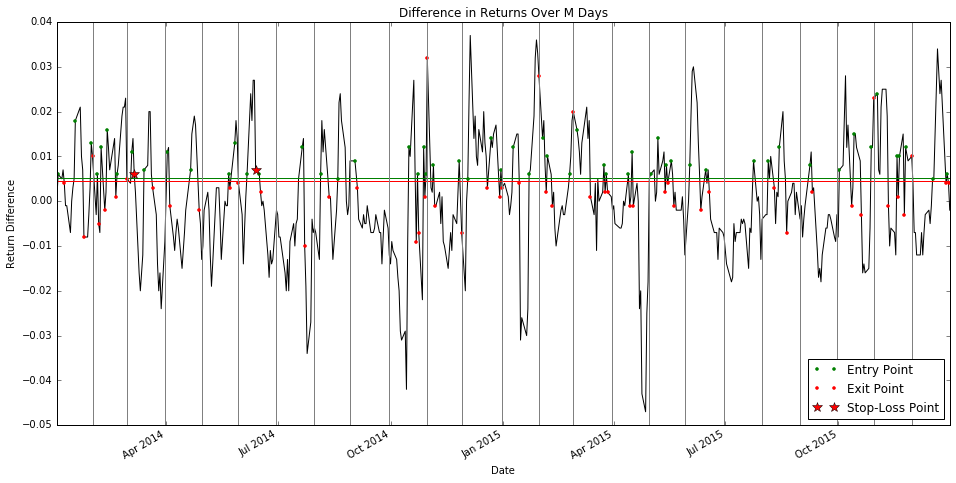

In [19]:
# plot DeltaM with entry and exit points
plt.figure(1,figsize=(16,8))
plt.title('Difference in Returns Over M Days')
plt.ylabel('Return Difference')
df.DeltaM.plot(color='black')
plt.axhline(y=0.0013*M,color='green')
plt.axhline(y=0.0011*M,color='red')
Entry_Pts = pd.DataFrame(df.Entry*df.DeltaM)
Entry_Pts = Entry_Pts[Entry_Pts != 0]
Exit_Pts = pd.DataFrame(df.Exit*df.DeltaM)
Exit_Pts = Exit_Pts[Exit_Pts != 0]
Stop_Pts = pd.DataFrame(df.Stop*df.DeltaM)
Stop_Pts = Stop_Pts[Stop_Pts != 0]
p1, = plt.plot(Entry_Pts,'g.')
p2, = plt.plot(Exit_Pts,'r.')
p3, = plt.plot(Stop_Pts,'r*',ms=10)
for i in range(0,len(df)):
    if df.EOM[i] == 1:
        plt.axvline(x=df.index[i],color='grey')
plt.legend([p1,p2,p3],['Entry Point','Exit Point','Stop-Loss Point'],loc='lower right')

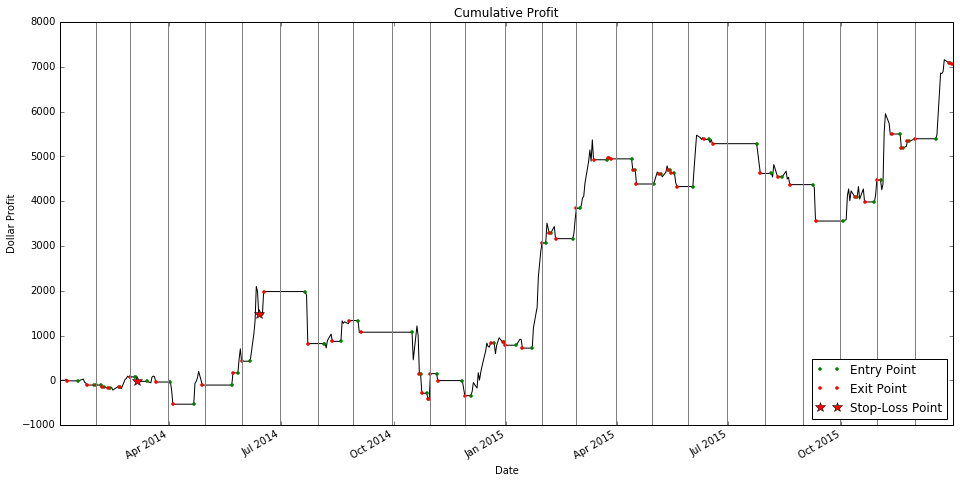

In [20]:
# plot cumulative profit
plt.figure(2,figsize=(16,8))
plt.title('Cumulative Profit')
plt.ylabel('Dollar Profit')
df.Cum_Profit.plot(color='black')
Entry_Pts = pd.DataFrame(df.Entry*df.Cum_Profit)
Entry_Pts = Entry_Pts[Entry_Pts != 0]
Exit_Pts = pd.DataFrame(df.Exit*df.Cum_Profit)
Exit_Pts = Exit_Pts[Exit_Pts != 0]
Stop_Pts = pd.DataFrame(df.Stop*df.Cum_Profit)
Stop_Pts = Stop_Pts[Stop_Pts != 0]
p1, = plt.plot(Entry_Pts,'g.')
p2, = plt.plot(Exit_Pts,'r.')
p3, = plt.plot(Stop_Pts,'r*',ms=10)
for i in range(0,len(df)):
    if df.EOM[i] == 1:
        plt.axvline(x=df.index[i],color='grey')
plt.legend([p1,p2,p3],['Entry Point','Exit Point','Stop-Loss Point'],loc='lower right')

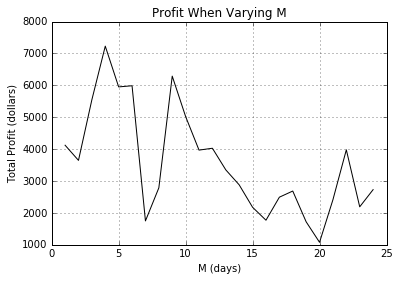

In [21]:
# check overall profit when varying M. need to make j g and s functions of M
Perform_M = pd.DataFrame(columns = ['M','Cum_Profit'])
for M in range(1,25):
  df = strat(M,0.0013*M,0.0011*M,0.10,'GOOG/NYSE_XSD','YAHOO/SMH','GOOG.NYSE_XSD - Close'
      ,'GOOG.NYSE_XSD - Volume','YAHOO.SMH - Close','YAHOO.SMH - Volume')
  Perform_M = Perform_M.append(pd.DataFrame([[M,df.Cum_Profit[-1]]],columns=['M','Cum_Profit']),
      ignore_index=True)
plt.figure(3)
plt.plot(Perform_M.M,Perform_M.Cum_Profit,color='black') # M=4 looks optimal
plt.title('Profit When Varying M')
plt.ylabel('Total Profit (dollars)')
plt.xlabel('M (days)')
plt.grid()

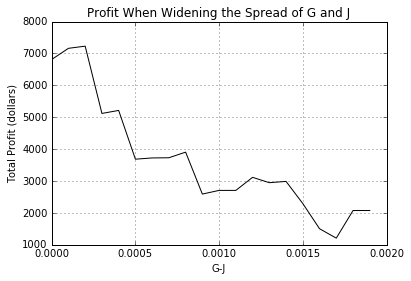

In [22]:
# check overall profit when widening the spread of g and j
Perform_W = pd.DataFrame(columns = ['W','Cum_Profit'])
M = 4
for i in range(0,20):
  i = i/20000
  G = 0.0012+i
  J = 0.0012-i
  df = strat(M,G*M,J*M,0.10,'GOOG/NYSE_XSD','YAHOO/SMH','GOOG.NYSE_XSD - Close'
      ,'GOOG.NYSE_XSD - Volume','YAHOO.SMH - Close','YAHOO.SMH - Volume')
  Perform_W = Perform_W.append(pd.DataFrame([[G,J,G-J,df.Cum_Profit[-1]]],columns=['G','J','W','Cum_Profit']),
      ignore_index=True)
plt.figure(4)
plt.plot(Perform_W.W,Perform_W.Cum_Profit,color='black') # window of 0.0011 looks good
plt.title('Profit When Widening the Spread of G and J')
plt.ylabel('Total Profit (dollars)')
plt.xlabel('G-J')
plt.grid()

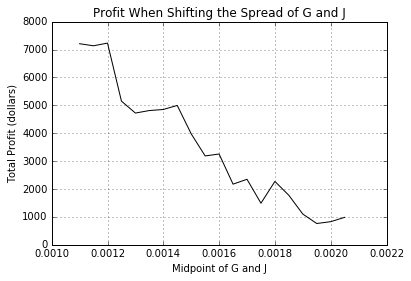

In [23]:
# check overall profit when shifting the spread of g and j
Perform_S = pd.DataFrame(columns = ['G','J','Cum_Profit'])
M = 4
for i in range(0,20):
  i = i/20000
  G = 0.0012+i
  J = 0.001+i
  df = strat(M,G*M,J*M,0.10,'GOOG/NYSE_XSD','YAHOO/SMH','GOOG.NYSE_XSD - Close'
      ,'GOOG.NYSE_XSD - Volume','YAHOO.SMH - Close','YAHOO.SMH - Volume')
  Perform_S = Perform_S.append(pd.DataFrame([[G,J,df.Cum_Profit[-1]]],
                                            columns=['G','J','Cum_Profit']),ignore_index=True)
plt.figure(5)
plt.plot((Perform_S.G+Perform_S.J)/2,Perform_S.Cum_Profit,color='black') # window of 0.005 looks good
plt.title('Profit When Shifting the Spread of G and J')
plt.ylabel('Total Profit (dollars)')
plt.xlabel('Midpoint of G and J')
plt.grid()